In [10]:
## Imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import glob
import os
import string
import random
import requests
import seaborn as sn
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.externals import *
from dateutil.parser import parse
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'
from nltk.corpus import stopwords
from nltk import *
from textblob import TextBlob, Word

# Exploration
#### This notebook outlines initial exploration of the dataset.

## Task 1: Explore subjects feature
We want to answer some basic questions about the subject feature. This might expose interesting topics to analyze in greater depth. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique subjects. How many different subjects are there? (what level of granularity are we getting here?)
- Find which subjects have more than 100 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [2]:
## Define paths
DATA_FOLDER = './data/'
TRAIN_PATH = DATA_FOLDER + 'train.tsv'
TEST_PATH = DATA_FOLDER + 'test.tsv'
VALID_PATH = DATA_FOLDER + 'valid.tsv'

In [3]:
# Data Loading

cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

train_data = pd.read_table(TRAIN_PATH, header=None) 
train_data.columns = cols

test_data = pd.read_table(TEST_PATH, header=None)
test_data.columns = cols

valid_data = pd.read_table(VALID_PATH, header=None)
valid_data.columns = cols

In [13]:
## Load raw data

df_raw = pd.concat([train_data, test_data, valid_data], axis=0, sort=False)
df_raw = df_raw.sample(frac=1).reset_index()
df_raw.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,7027,7112.json,true,Says Fran DeWines made-from-scratch dinner rol...,families,mike-dewine,Ohio attorney general,Ohio,republican,2.0,0.0,3.0,1.0,0.0,a news release
1,3752,429.json,true,"As a state senator, he (Obama) even refused to...",legal-issues,focus-family-action,NaN,NaN,none,1.0,2.0,0.0,0.0,0.0,an article written by Tom Minnery


In [14]:
## Check types and shape
print(df_raw.dtypes)
print(df_raw.shape)

index                  int64
ID                    object
label                 object
statement             object
subject               object
speaker               object
job                   object
state                 object
party                 object
barely_true_cts      float64
false_cts            float64
half_true_cts        float64
mostly_true_cts      float64
pants_on_fire_cts    float64
context               object
dtype: object
(12791, 15)


In [15]:
## Help put data in useful form - split topics as list and separate into new rows for grouping
## Split subjects into lists
subject_split = df_raw.copy()
subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
subject_split.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,7027,7112.json,true,Says Fran DeWines made-from-scratch dinner rol...,[families],mike-dewine,Ohio attorney general,Ohio,republican,2.0,0.0,3.0,1.0,0.0,a news release
1,3752,429.json,true,"As a state senator, he (Obama) even refused to...",[legal-issues],focus-family-action,NaN,NaN,none,1.0,2.0,0.0,0.0,0.0,an article written by Tom Minnery


In [16]:
set_of_subjects = set()
for subject_list in subject_split['subject'].values:
    set_of_subjects |= set(subject_list)
    
print("There are %d unique subjects" % len(set_of_subjects))
print("Some sample subjects include:\n", list(set_of_subjects)[:5])

There are 145 unique subjects
Some sample subjects include:
 ['abc-news-week', 'recreation', 'elections', 'colbert-report', 'history']


In [17]:
## Create a dataframe of all subjects
subjects = subject_split.subject.apply(pd.Series)
new_cols = cols.copy()
new_cols.remove("subject")

## Now merge with original frame to create separate columns for each subject
## Then melt so that each entry exists under several subjects
subject_split = subjects.merge(subject_split, right_index = True, left_index = True) \
    .drop(["subject"], axis = 1) \
    .melt(id_vars = new_cols, value_name = "subject") \
    .drop("variable", axis = 1) \
    .dropna()

subject_split.head(2)

,ID,label,statement,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,subject
0,7112.json,true,Says Fran DeWines made-from-scratch dinner rol...,mike-dewine,Ohio attorney general,Ohio,republican,2.0,0.0,3.0,1.0,0.0,a news release,families
2,9146.json,mostly-true,"By a two-to-one margin, Rhode Islanders want t...",linda-finn,landscape designer,Rhode Island,democrat,0.0,0.0,1.0,2.0,0.0,a speech during a rally at the Rhode Island st...,government-regulation


We notice that many subjects have very few instances within the dataset. 
We want to limit ourselves to subjects that are mentioned with reasonable frequency.
We choose to only include subjects that appear more than 100 times.

In [18]:
subject_counts = subject_split.groupby("subject").count()
subjects_over_100 = subject_counts.where(subject_counts['ID'] > 100).dropna().index
subject_split = subject_split[subject_split['subject'].isin(subjects_over_100)]

print("There are %d unique subjects that have over 100 corresponding statements" % len(subjects_over_100))

There are 54 unique subjects that have over 100 corresponding statements


By limiting out subjects to those that appear frequently, we have a small enough set to do some useful visual analysis.

In [19]:
def by_label(df, column):
    return df.groupby([column,"label"]).agg({"ID" : "count"})

breakdown = by_label(subject_split, 'subject')
breakdown.head()

ID
subject  label          
abortion barely-true  37
         false        30
         half-true    39
         mostly-true  25
         pants-fire   12

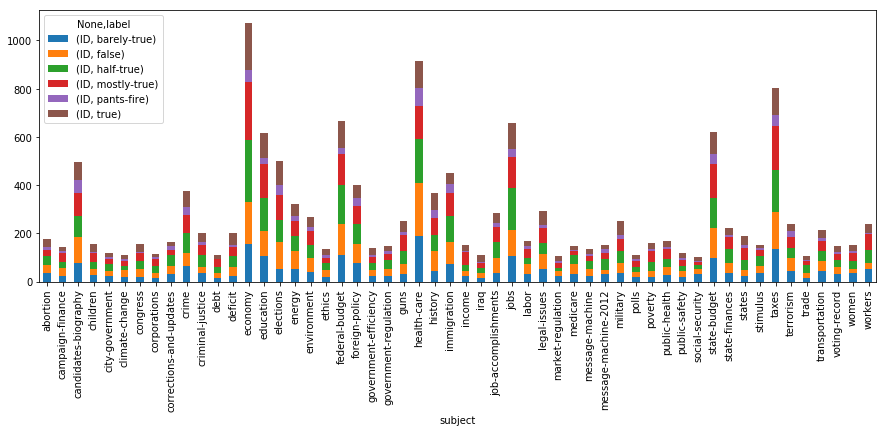

In [20]:
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [21]:
def normalize(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return bd_norm

bd_norm = normalize(breakdown, 'subject')

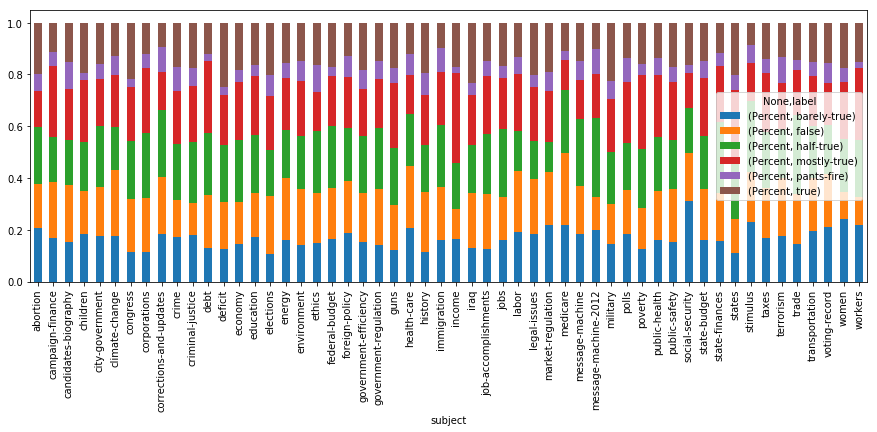

In [22]:
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

Above, we can see from our un-normalized plot the distribution of topics as well as their respective distribution of truth classifications. From the normalized plot, we see can more easily see the distribution of truth classifications.

We may be interested in making a simpler classification, such as 'false' versus 'not false'. In this way, we regard 'pants-fire' and 'false' as a false tags, and all others are those statements with at least a small degree of truth within.

In [23]:
def transform_tf(df, column):
    tf_breakdown = df.copy()
    tf_breakdown['false'] = ~(tf_breakdown['label'].isin(['false', 'pants-fire']))

    tf_breakdown = tf_breakdown.groupby([column,"false"]).agg({"ID" : "count"})
    return tf_breakdown

tf_breakdown = transform_tf(subject_split, 'subject')

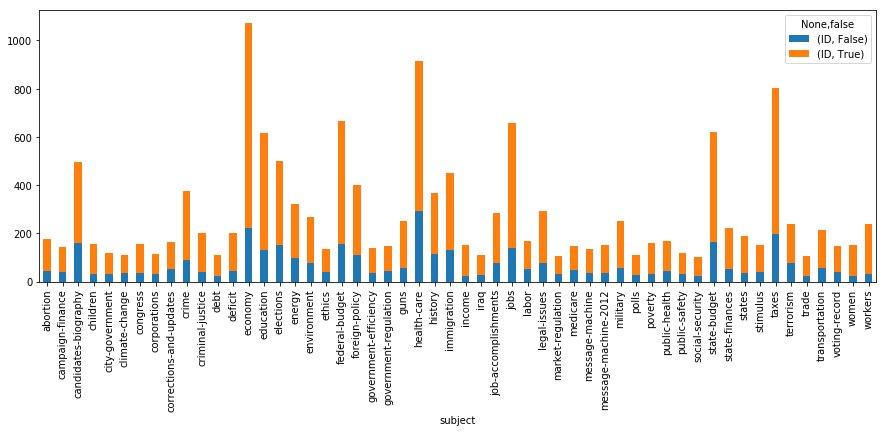

In [24]:
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [25]:
def normalize_tf(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'false'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'false'])
    return bd_norm

bd_norm = normalize_tf(tf_breakdown, 'subject')
bd_norm.head()

Percent
subject              false          
abortion             False  0.235955
                     True   0.764045
campaign-finance     False  0.272727
                     True   0.727273
candidates-biography False  0.323887

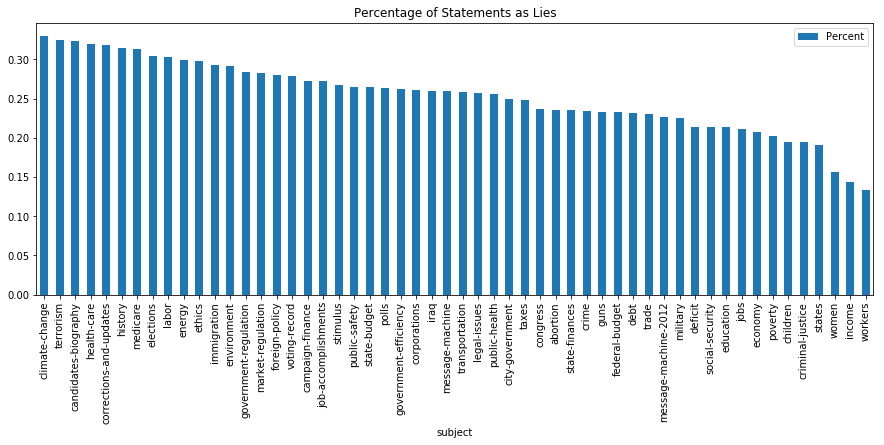

In [26]:
def plot_truthfulness(df, column):
    df_ri = df.reset_index()
    tf = df_ri[~df_ri['false']][[column, 'Percent']]
    tf = tf.sort_values('Percent', ascending=False)
    tf.plot(x=column,kind='bar', title="Percentage of Statements as Lies", figsize=(15,5))
    
plot_truthfulness(bd_norm, "subject")

### Task 1: Interpretation
We note that of the topics discussed often in the liar dataset, medicare and terrorism have the most lies. While we note the percentages are quite high, we note that statements from this dataset are by dy default disputed so this is not unexpected. However, assuming the dataset was not gathered with a particularly subject bias, the relative truth rate between subjects could be meaningful. It is possibly worth looking in to Note that this analysis does not consider consider half-true as a lie.

## Task 2: Explore speaker feature
We want to answer some basic questions about the speaker feature. This might expose interesting topics to analyze in greater depth because it is likely that different speakers have different levels of truthfulness. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique speakers. How many different speakers are there?
- Find which speakers have more than 50 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [27]:
speakers_df = df_raw.copy()
speakers = speakers_df['speaker'].unique()
print("There are %d unique speakers" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 3310 unique speakers
Some sample speakers include:
 ['mike-dewine' 'focus-family-action' 'linda-finn' 'chuck-baldwin'
 'holly-turner']


In [28]:
speakers_cts = speakers_df.groupby("speaker").statement.count()
speakers = speakers_cts[speakers_cts > 50]
print("There are %d unique speakers who appear more than 50 times within the dataset" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 29 unique speakers who appear more than 50 times within the dataset
Some sample speakers include:
 speaker
barack-obama     611
bernie-s         106
blog-posting      81
chain-email      178
charlie-crist     90
Name: statement, dtype: int64


In [29]:
## Limit ourselves to only prominent speakers for visualization
speakers_df = speakers_df[speakers_df['speaker'].isin(speakers.keys())]

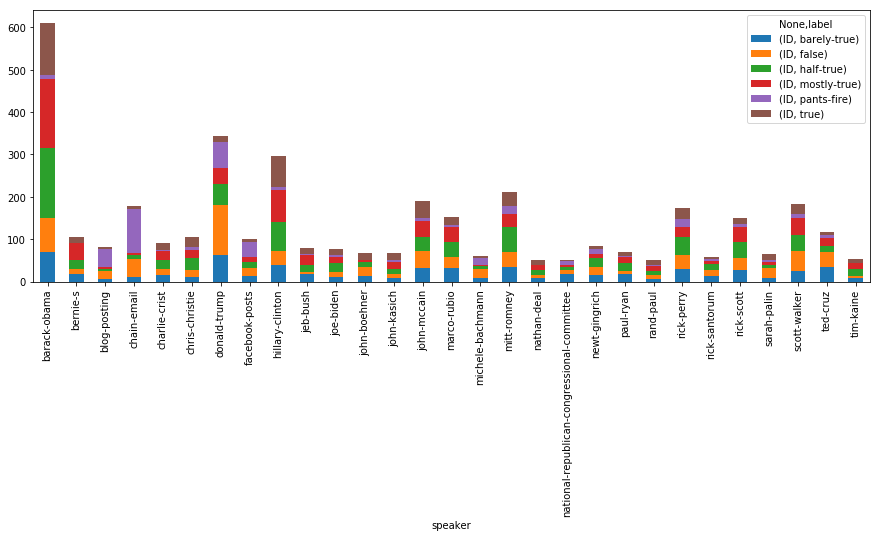

In [30]:
breakdown = by_label(speakers_df, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

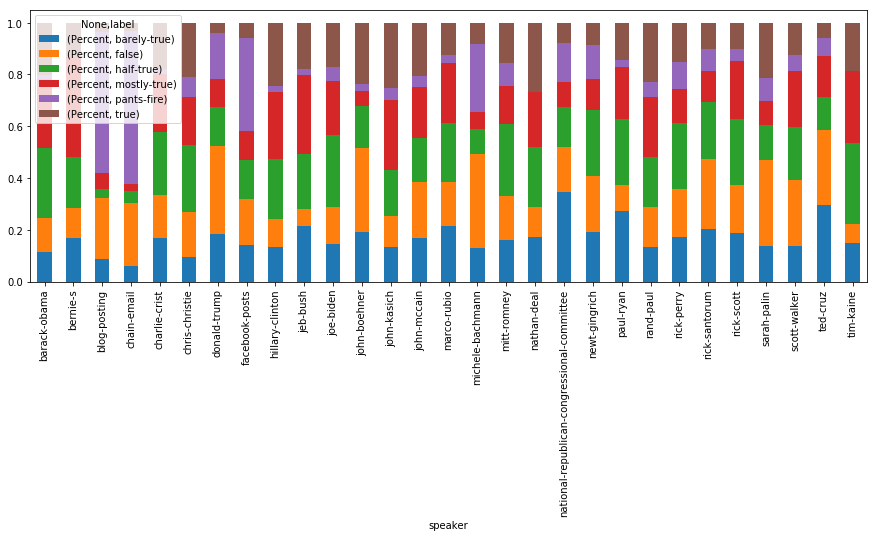

In [31]:
bd_norm = normalize(breakdown, 'speaker')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

From this, we can see a few interesting findings. It seems that Facebook posts, chain emails and Donald Trump are trastically more likely to be 'pants-fire' lies, which are the most obvious and blatantly false types of lies of the possible labels. We also see that most other speakers maintain a very much smaller 'pants-fire' rate.

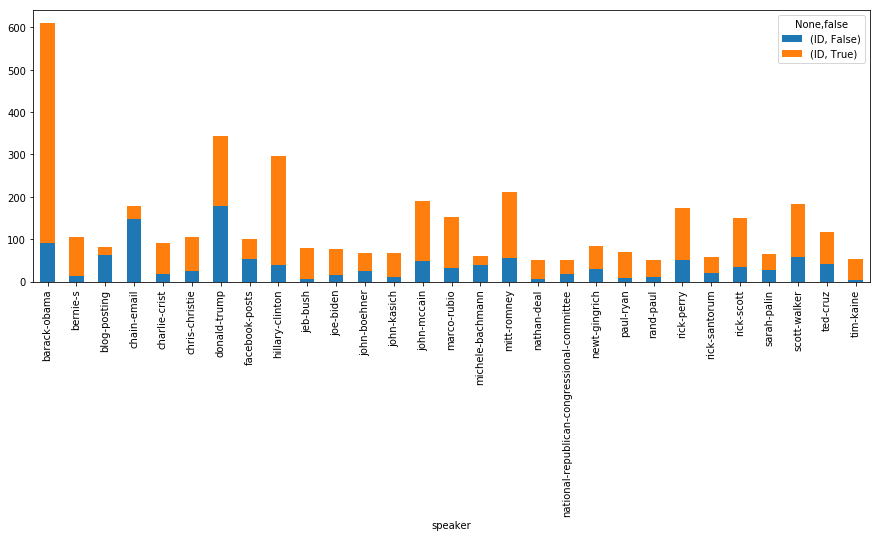

In [32]:
tf_breakdown = transform_tf(speakers_df, 'speaker')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

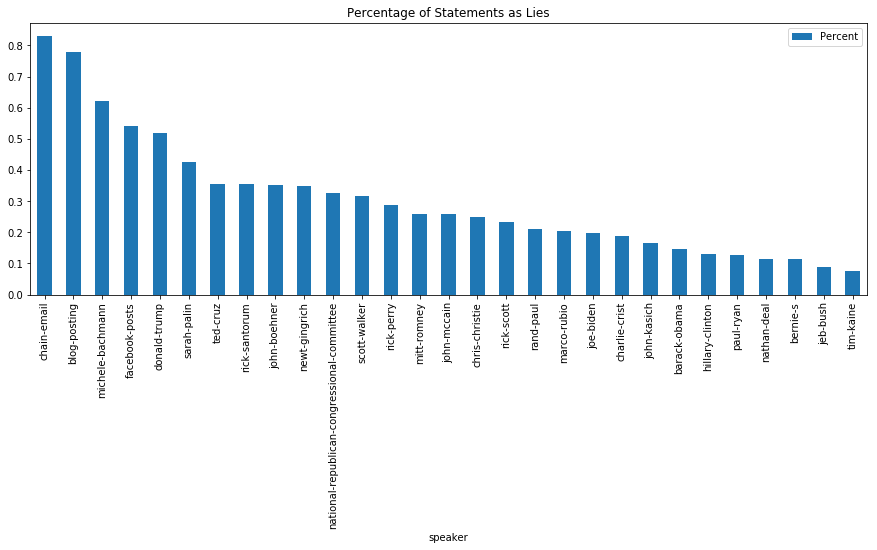

In [33]:
bd_norm = normalize_tf(tf_breakdown, 'speaker')
plot_truthfulness(bd_norm, 'speaker')

### Task 2: Interpretation
In breaking down our dataset by the speakers, we see some interesting trends, due to the fact that speakers can be both people as well as websites/communication mediums. In looking at our most prominent sources, we see that anonymous media tend to have the highest untruthfulness rate. The only person who who lies more than one of the anonymous media is Donald Trump, whose overall rate of lying is greater than Facebook posts. That said, we also see that Facebook posts proportionally are more 'pants-fire' type lies. Donald Trump has proportionally fewer 'pants-fire' lies, but drastically more 'false' lies.

We also note that chain-emails are heinously untruthful. Of the ones examined in this dataset, over 80% are either false or 'pants-fire' false.

## Task 3: Locational analysis
We note that our dataframe has state information for each of the statements. We would like to see how the rate of lies varies within states by:
- Creating a heatmap of lies from the dataset.

In [34]:
# Computing percentage of lies

states_lies_count = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby('state').state.count()
states_count = df_raw.groupby('state').state.count()
states_tot_false = pd.concat([states_count, states_lies_count], axis=1, sort=True).dropna()
states_tot_false.columns = ['count_tot', 'count_false']
states_tot_false.count_false = states_tot_false.count_false.astype('int64')
states_tot_false['perc_lies'] = (states_tot_false.count_false / states_tot_false.count_tot) * 100
states_tot_false.reset_index(inplace=True)
states_tot_false.columns = ['state', 'count_tot', 'count_false', 'perc_lies']
states_tot_false.head()

,state,count_tot,count_false,perc_lies
0,Alabama,18,7,38.888889
1,Alaska,81,34,41.975309
2,Arizona,228,60,26.315789
3,Arkansas,103,20,19.417476
4,California,180,47,26.111111


In [35]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

get_state_names = lambda x: x['properties']['name']
geo_states = set(map(get_state_names, geo_json_data['features']))
df_states = set(states_tot_false['state'])
to_add = geo_states - df_states

In [36]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_tot_false,
             columns=['state', 'perc_lies'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of lies (%)')
us_map

### Task 3: Interpretation
From here we see lies being more prominent in Montana than anywhere else, while Tennessee, Mississippi, West Virginia also are prominent. Ultimately, we do not see much geographical clustering, and even if we thought to note the general trend for higher lie rate in southern states, this does not seem to hold very well considering Arkansas and North Carolina. This may ultimately just be a heatmap of the states of the political speakers within the dataset, so this may not be useful in our further analysis.

## Task 4: Explore job feature
The dataframe contains jobs of each of the speakers. We will perform similar analysis as with our other features, in order to see how well job analysis relates to truthfulness:
- Find all unique jobs. How many different subjects are there?
- Find a way to visualize how truth relates to this feature.

In [37]:
jobs_df = df_raw.copy()
jobs = jobs_df['job'].unique()
print("There are %d unique jobs" % len(jobs))
print("Some sample jobs include:\n", jobs)

There are 1356 unique jobs
Some sample jobs include:
 ['Ohio attorney general' nan 'landscape designer' ...
 'lobbyist, Rhode Island State Association of Firefighters'
 'education analyst' 'Editorial director, Huffington Post']


Similar to above, there are too many unique jobs to query. So we will look at the most common jobs.

In [38]:
job_cts = jobs_df.groupby("job").statement.count()
jobs = job_cts[job_cts > 20]
print("There are %d unique jobs who appear more than 20 times within the dataset" % len(jobs))
print("Some sample jobs include:\n", jobs[:5])

There are 65 unique jobs who appear more than 20 times within the dataset
Some sample jobs include:
 job
Actor                                       22
Attorney                                   110
Attorney General                            37
Businessman                                 45
Candidate for U.S. Senate and physician     52
Name: statement, dtype: int64


In [39]:
## Limit ourselves to only prominent speakers for visualization
jobs_df = jobs_df[jobs_df['job'].isin(jobs.keys())]

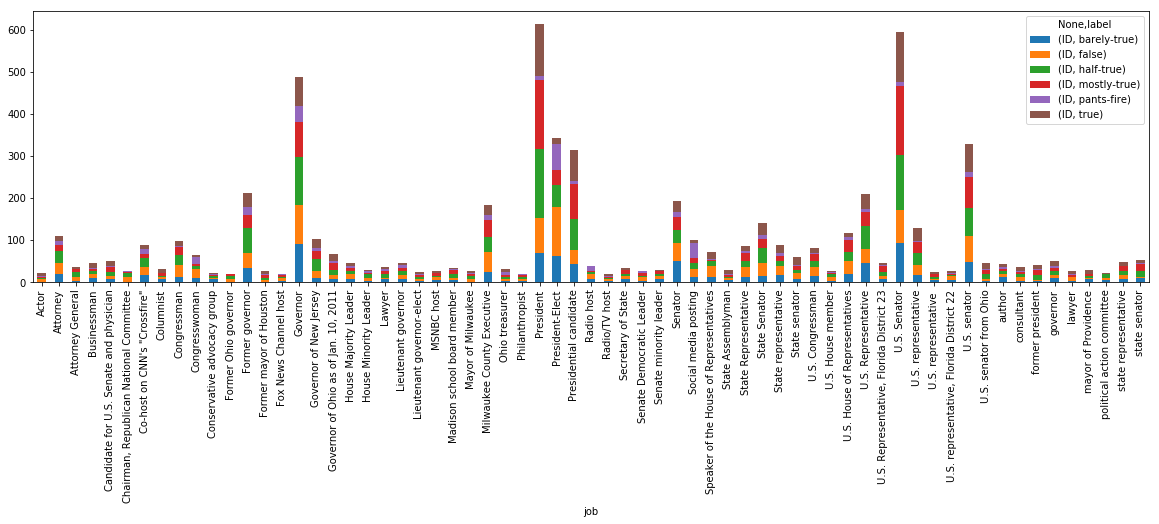

In [40]:
breakdown = by_label(jobs_df, 'job')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))

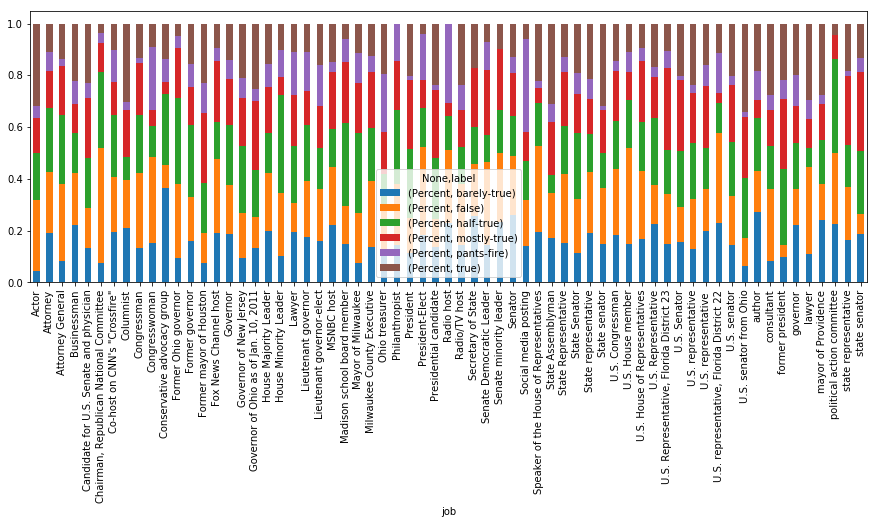

In [41]:
bd_norm = normalize(breakdown, 'job')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

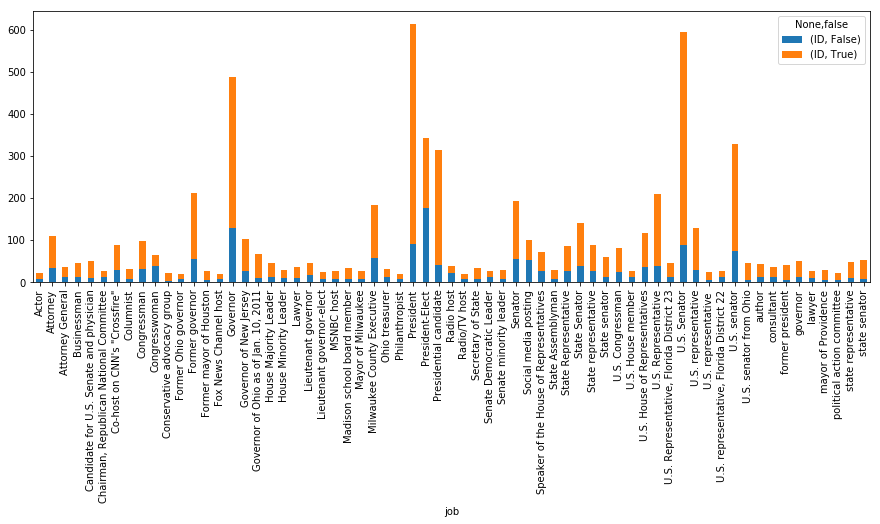

In [42]:
tf_breakdown = transform_tf(jobs_df, 'job')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

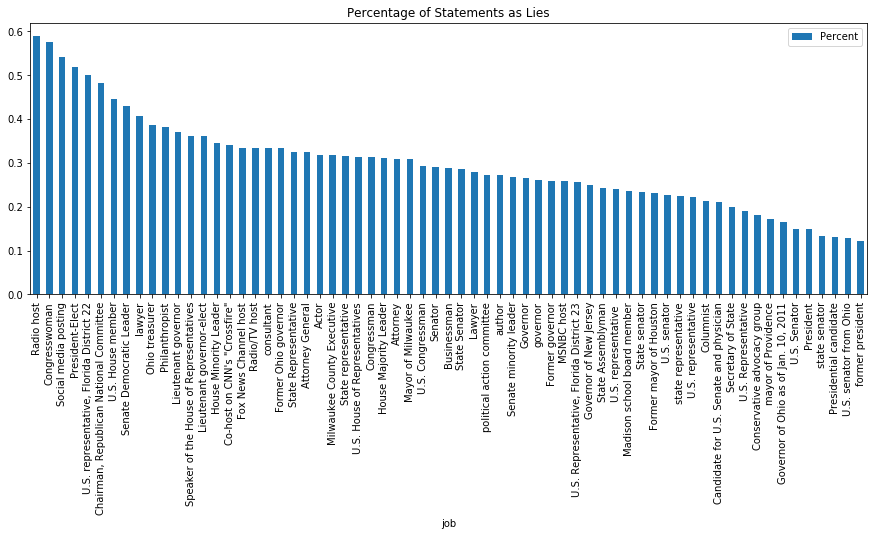

In [43]:
bd_norm = normalize_tf(tf_breakdown, 'job')
plot_truthfulness(bd_norm, 'job')

### Task 4: Interpretation
This analysis must be interpreted with knowledge of the time constraints of the dataset. In the years 2007-2017, there were only two President-Elects, one of whom is one of the most consistent liars as shown in the analysis above. Additionally, congresswoman may only refer to a very small number of people within the dataset. This can be said for many of the jobs, such as Ohio treasurer and House Majority Leader.

It is notable that Radio hosts, businessmen and attorneys are all fairly generic jobs that have high instances of falsehoods in this dataset.

## Task 5: Explore the party feature
Using similar analysis as above, we will explore one other relevant feature within the dataset, which is political party affiliation:
- Find a way to visualize how truth relates to this feature.

In [44]:
parties_df = df_raw.copy()
parties = jobs_df['party'].unique()
print("There are %d unique parties" % len(parties))
print("Some sample parties include:\n", parties)

There are 9 unique parties
Some sample parties include:
 ['republican' 'democrat' 'columnist' 'none' 'independent' 'Moderate'
 'libertarian' 'constitution-party' 'business-leader']


In [45]:
parties_cts = parties_df.groupby("party").statement.count()
parties = parties_cts[parties_cts > 20]
print("There are %d unique affiliations who appear more than 20 times within the dataset" % len(parties))
print("Some sample affiliations include:\n", parties[:5])

There are 12 unique affiliations who appear more than 20 times within the dataset
Some sample affiliations include:
 party
activist         45
columnist        44
democrat       4137
independent     180
journalist       49
Name: statement, dtype: int64


In [46]:
## Limit ourselves to only prominent speakers to remove edge cases
parties_df = parties_df[parties_df['party'].isin(parties.keys())]

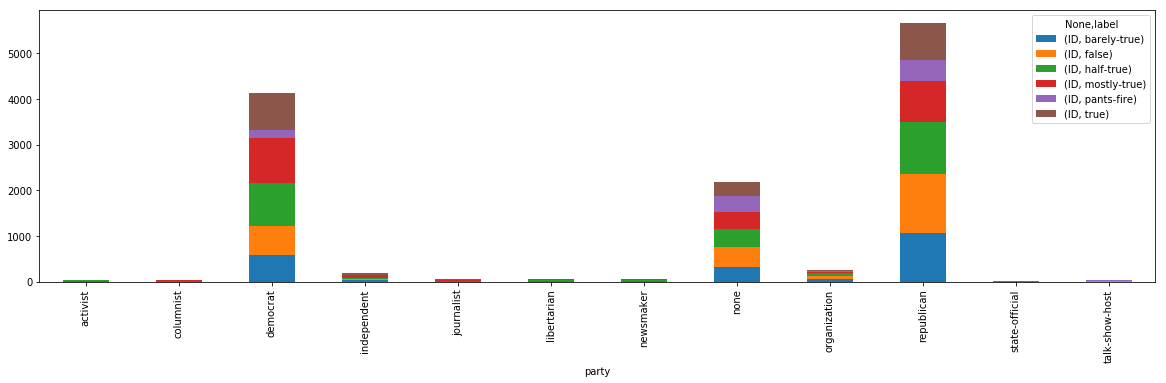

In [47]:
breakdown = by_label(parties_df, 'party')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))

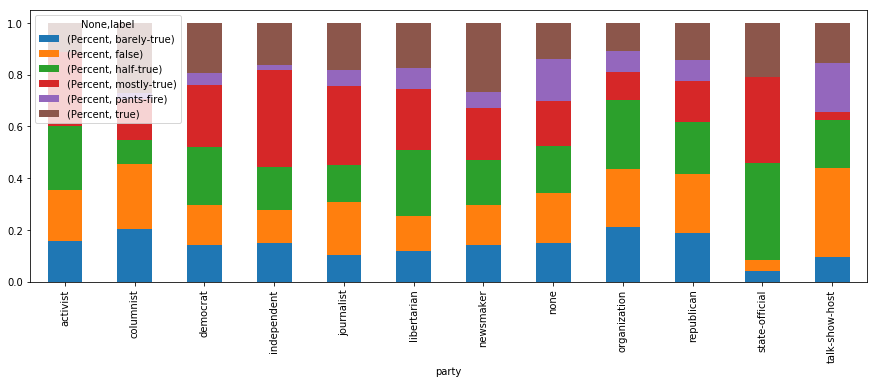

In [48]:
bd_norm = normalize(breakdown, 'party')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

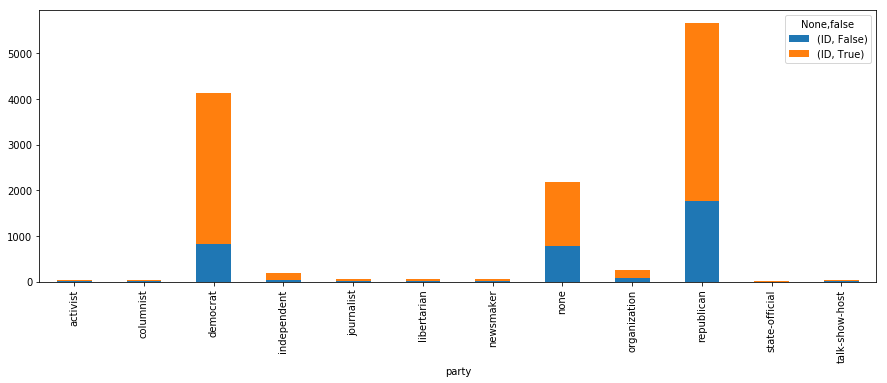

In [49]:
tf_breakdown = transform_tf(parties_df, 'party')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

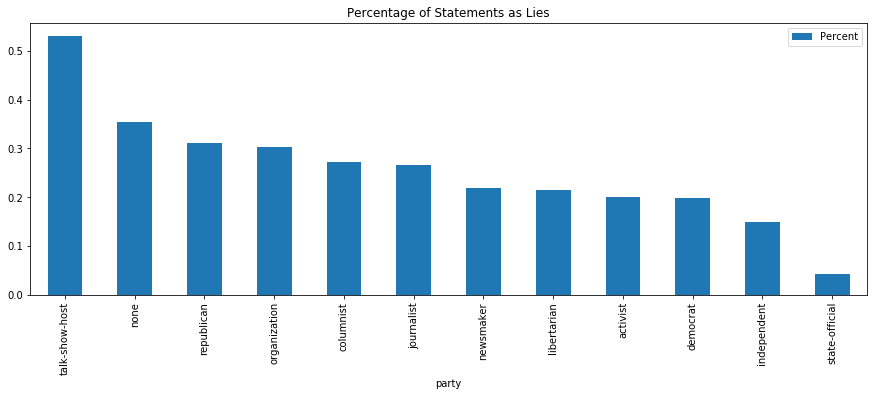

In [50]:
bd_norm = normalize_tf(tf_breakdown, 'party')
plot_truthfulness(bd_norm, 'party')

### Task 5: Interpretation
This task has some interesting results. Extreme values seem to be dominated not by the standard two American political parties. We see talk-show-host being by far the least truthful affiliation. This is interesting because talk shows very often have a political bias, but for purposes of this dataset they are not strictly affiliated. This also shows that this feature has a lot of redundance with the features above - job and speaker often define party affiliation.

## Task 6: Measure interaction between affiliation and job
Prior to this point, we have performed single variable analysis of the features within the dataset. Here we will begin looking at interactions between features. In this task, we want to analyze and visualize how the features interact. We do so by:
- Finding the jobs with the highest rate of lies.
- Finding the parties with the highest rate of lies.
- Find the job/party combinations with the highest rate of lies.
- Breakdown and visualize the effect party has on truthfulness for each of the high lie rate jobs.

In [51]:
# Capture jobs with more lies
job_false = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby("job").ID.count()
job_false_df = pd.DataFrame(job_false).reset_index()
job_false_df.columns = ['job', 'false_count']
job_false_df_max = job_false_df.sort_values(by='false_count' ,ascending=False).head(20)

In [52]:
# Capture parties with more lies
party_false = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby("party").ID.count()
party_false_df = pd.DataFrame(party_false).reset_index()
party_false_df.columns = ['party', 'false_count']
party_false_df_max = party_false_df.sort_values(by='false_count' ,ascending=False).head(20)

In [53]:
# Analyze both at the same time
party_job_false = df_raw[df_raw.label == "false"].groupby(["job", "party"]).ID.count()
party_job_false_df = pd.DataFrame(party_job_false).reset_index()
party_job_false_df.columns = ['job', 'party', 'false_count']
party_job_false_df_sorted = party_job_false_df.sort_values(by='false_count' ,ascending=False)

In [54]:
merge_party_job = party_job_false_df_sorted.merge(party_job_false_df_sorted, on='job')
merge_party_job = merge_party_job[(merge_party_job.party_x == 'republican') & (merge_party_job.party_y == 'democrat')]
merge_party_job = merge_party_job.sort_values(by='false_count_x', ascending=False)
data_matrix = merge_party_job.iloc[:4]
data_matrix

,job,party_x,false_count_x,party_y,false_count_y
2,Governor,republican,83,democrat,10
11,U.S. senator,republican,46,democrat,16
15,U.S. Senator,republican,45,democrat,23
24,Senator,republican,39,democrat,4


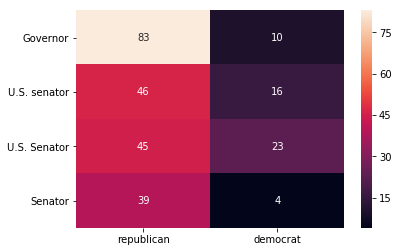

In [55]:
sns.heatmap(np.matrix(data_matrix[['false_count_x', 'false_count_y']]), annot=True, fmt="d", xticklabels=['republican', 'democrat'], yticklabels=data_matrix['job'])

It appears as though republican governors have drastically higher rate of lying than democrats. We observed before that republicans had only a marginally higher lying rate. So we want to see if the recorded governor statements themselves lean toward statements from republican governors.

In [56]:
governors = jobs_df[jobs_df['job']=='Governor']
governors[['speaker', 'job', 'party']].drop_duplicates().head()

,speaker,job,party
15,rick-scott,Governor,republican
23,rick-perry,Governor,republican
55,bob-mcdonnell,Governor,republican
85,mike-pence,Governor,republican
626,bill-haslam,Governor,republican


In [57]:
governors.groupby('party').job.count()

party
democrat       66
republican    421
Name: job, dtype: int64

### Task 6: Interpretation
In this task we see some possible interaction between the features. We noted earlier that the rate of lies was higher for Republicans than democrats, but this seems especially pronounced for governors. This leads us to question whether or not there simply tend to be more republican governors sampled than democrats. This ends up being the case, with over 6 times the amount of statements taken from republican governors than democratic governors. This reveals a bias within the sampling of the dataset which we must be careful for when constructing models or trying to make future analysis.

## Task 7: Create a rudimentary model
For this project, we will ultimately be using the findings above as well as additional tools to augment our dataset for underlying features. We will make an initial model in the exploration step simply to establish a baseline from which to improve.

While it is notable that this is not simply a machine learning exercise, we believe that improvement of the model can be some indication of relevance of the additionally analysis we perform in augmenting the data set to expose new relations that can hopefully be predictive.

In [58]:
def preprocess_data(data):
    subject_split = data.copy()
    subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
    subjects = subject_split.subject.apply(pd.Series)
    new_cols = cols.copy()
    new_cols.remove("subject")

    ## Now merge with original frame to create separate columns for each subject
    ## Then melt so that each entry exists under several subjects
    subject_split = subjects.merge(subject_split, right_index = True, left_index = True).drop(["subject"], axis = 1).melt(id_vars = new_cols, value_name = "subject").drop("variable", axis = 1).dropna()
    
    # Manually cleaning state field
    subject_split['state'] = subject_split['state'].apply(lambda x: "Washington" if x == "Washington, D.C." or x == "Washington, D.C. " or x == "Washington state" or x == "Washington DC" or x == "Washington D.C." else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Wisconsin" if x == "Wisconsin " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Ohio" if x == "ohio" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "New York" if x == "New York " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Illinois" if x == "Illinois " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Georgia" if x == "Georgia " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Florida" if x == "Florida " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Colorado" if x == "Colorado " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Massachusetts" if x == "Massachusetts " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Pennsylvania" if x == "PA - Pennsylvania" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Tennessee" if x == "Tennesse" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Virginia" if x == "Virgiia" or x == "Virgina" or x == "Virginia " or x == "Virginia director, Coalition to Stop Gun Violence" else x)
    
    # Cleaning context field
    subject_split['context'] = subject_split['context'].apply(lambda x: "a speech" if x == "a speech." or x == "in a speech" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television interview" if x == "a TV interview" or x == "a TV interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a debate" if x == "a debate." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a radio interview" if x == "a radio interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "an interview" if x == "an interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television commercial" if x == "a TV commercial" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television ad" if x == "a TV ad." or x == "a TV ad" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a press release" if x == "a press release." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a news release" if x == "a news release." else x)
    
    # Cleaning job field
    subject_split['job'] = subject_split['job'].apply(lambda x: "Governor" if x == "governor" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Senator" if x == "U.S. senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Representative" if x == "U.S. representative" or x == "U.S. House of Representatives" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Representative" if x == "State representative" or x == "state representative" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
    
    return subject_split

In [59]:
# Loading data and preprocessing
data = df_raw.copy()

clean_data = preprocess_data(data)

In [60]:
# Converting in categorical variables and factorizing label

dataset = clean_data.drop(columns=["ID", "statement"])
factor = pd.factorize(dataset['label'])
dataset.label = factor[0]
definitions = factor[1]

dummy_dataset = pd.get_dummies(dataset)

In [61]:
# Splitting data 

X = dummy_dataset.iloc[:,1:].values
y = dummy_dataset.iloc[:,0].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [62]:
# Standardizing data

std_scaler = StandardScaler()
X_tr = std_scaler.fit_transform(X_tr)
X_te = std_scaler.transform(X_te)

In [63]:
# Training and de-factorization

classifier = RandomForestClassifier(n_estimators = 500)

classifier.fit(X_tr, y_tr)

probs = classifier.predict(X_te)

reversefactor = dict(zip(range(5),definitions))

y_true = np.vectorize(reversefactor.get)(y_te)

y_pred = np.vectorize(reversefactor.get)(probs)

KeyboardInterrupt: 

In [ ]:
# Confusion matrix
pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
# Accuracy
accuracy_score(y_true, y_pred)

In [ ]:
# F1 score
f1_score(y_true, y_pred, average="micro")

### Task 7: Interpretation
Our rudimentary model has much better than random accuracy in classifying the testing data, especially given that this dataset exists in 6 classes, rather than being a binary classification. That said, the accuracy is still not exceptional.

## Data augmentation with politifact data

In [157]:
# Loading data from politifact
pol_train_set = pd.read_pickle("data/train_politifact")
pol_test_set = pd.read_pickle("data/test_politifact")
pol_valid_set = pd.read_pickle("data/valid_politifact")

In [75]:
poli_data = pd.concat([pol_train_set, pol_test_set, pol_valid_set], axis=0, sort=False)
poli_data = poli_data.sample(frac=1).reset_index()

In [76]:
poli_data.columns

Index(['index', 'art', 'author', 'canonical_url', 'edition', 'editor',
       'facebook_headline', 'id', 'in_future', 'is_pundit', 'make_public',
       'preview', 'researcher', 'resource_uri', 'ruling', 'ruling_comments',
       'ruling_comments_date', 'ruling_date', 'ruling_headline',
       'ruling_headline_slug', 'ruling_link_text', 'ruling_state',
       'source_documents', 'sources', 'speaker', 'statement',
       'statement_context', 'statement_date', 'statement_type', 'subject',
       'target', 'twitter_headline'],
      dtype='object')

In [79]:
# Merging with Politifact data with the Liar dataset

df_raw["id_clean"] = df_raw.ID.str[:-5]
df_raw.id_clean = pd.to_numeric(df_raw.id_clean)
df_raw_aug = poli_data.merge(df_raw, left_on="id", right_on="id_clean")

In [82]:
df_raw_aug.head(5)

,index_x,art,author,canonical_url,edition,editor,facebook_headline,id,in_future,is_pundit,...,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,id_clean
0,8572,[],"[{'email_address': 'abettelheim@cq.com', 'firs...",/truth-o-meter/statements/2008/feb/12/hillary-...,"{'adkey': 'Editions', 'advalue': 'National', '...","[{'email_address': 'ahollyfield@tampabay.com',...",None,351,False,False,...,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a conference call to reporters led by Cilnton ...,351
1,1141,[],[{'email_address': 'truthometer@politifact.com...,/truth-o-meter/statements/2009/aug/07/john-boe...,"{'adkey': 'Editions', 'advalue': 'National', '...","[{'email_address': 'bill.adair@duke.edu', 'fir...",None,1120,False,False,...,Speaker of the House of Representatives,Ohio,republican,13.0,22.0,11.0,4.0,2.0,an op-ed for National Review,1120
2,3208,"[{'brightcove': '', 'caption': 'In this video ...","[{'email_address': 'wgstexas@gmail.com', 'firs...",/texas/statements/2014/jun/22/texas-future/tex...,"{'adkey': 'Editions', 'advalue': 'Texas', 'edi...","[{'email_address': 'ddavis@statesman.com', 'fi...",None,9481,False,False,...,501 (c) (4) educational group,NaN,none,0.0,0.0,1.0,0.0,0.0,a web video,9481
3,301,"[{'brightcove': '', 'caption': 'A bill signed ...",[{'email_address': 'tkertscher@journalsentinel...,/wisconsin/statements/2013/jul/12/rachel-campo...,"{'adkey': 'Editions', 'advalue': 'Wisconsin', ...",[{'email_address': 'gborowski@journalsentinel....,None,8004,False,False,...,NaN,NaN,none,0.0,1.0,0.0,0.0,0.0,an interview,8004
4,1153,[],"[{'email_address': 'aholan@poynter.org', 'firs...",/truth-o-meter/statements/2010/jul/02/barack-o...,"{'adkey': 'Editions', 'advalue': 'National', '...","[{'email_address': 'truthometer@gmail.com', 'f...",None,1996,False,False,...,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a speech,1996


## Task 8: Date tracking
Each of the entries of the dataset is accompanied with a corresponding json ID. Because all of these are sampled from Politifacts, we can query to find more information. In this task we:
- Create a routine to query Politifacts for dates for each entry.
- Visualize the findings.

In [141]:
df = pd.DataFrame(df_raw_aug[["statement_date", "label", "ID"]])

In [142]:
df["year"] = df.statement_date.str[:4]
df.drop(df[(df["year"] == "1995") | (df["year"] == "2000") | (df["year"] == "2002")].index, inplace=True)

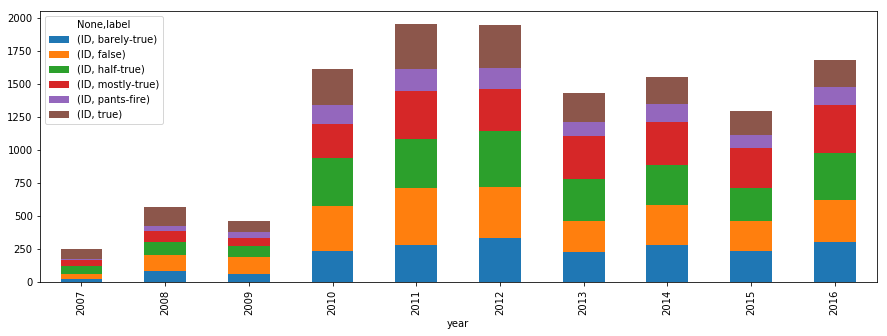

In [143]:
breakdown = by_label(df, 'year')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

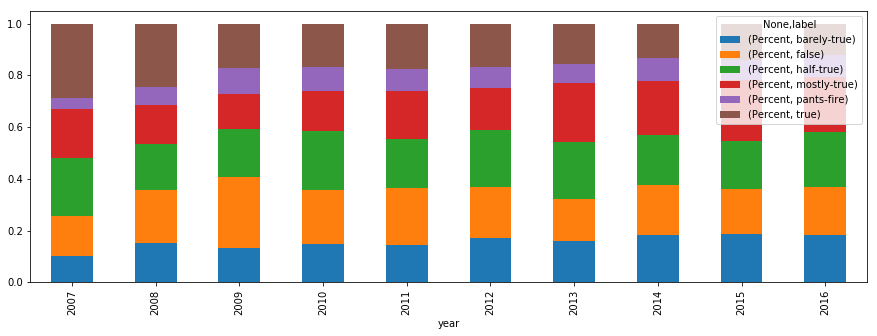

In [144]:
bd_norm = normalize(breakdown, 'year')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

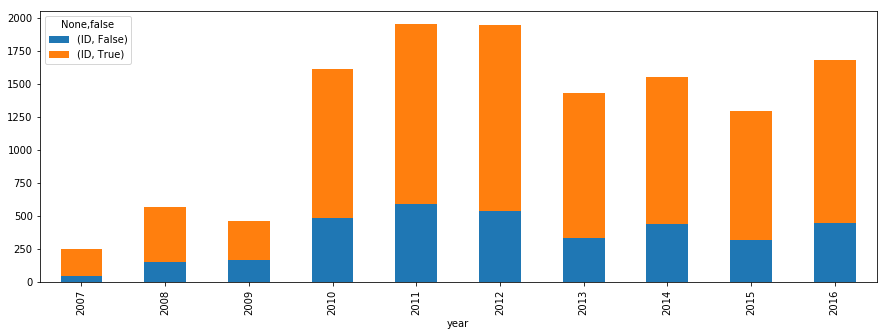

In [145]:
tf_breakdown = transform_tf(df, 'year')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

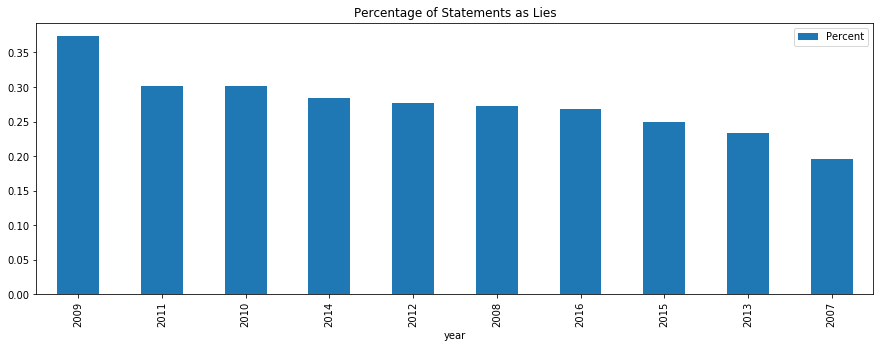

In [146]:
bd_norm = normalize_tf(tf_breakdown, 'year')
plot_truthfulness(bd_norm, 'year')

### Overall Interpretations

In this notebook, we have gathered insights to proceed in augmenting the data set. In the future, we will see if augmentations can help improve this accuracy (indicating that underlying features might be important in discrimination of the data) as well try to see how generalizable these findings are to other datasets. In specific, we note that the topic, speaker and party each seemed to be reasonable predictive features. We have noted in many places that anonymity seemed to increase lack of truthfulness. Additionally, we found that the location of the statement did not seem to be a particularly strong indicator as most location trends seemed to only hold in certain cases. We also found some inherent biases in the collection of the dataset, whereby some job statements were sampled much higher for republicans than democrats. This would lead a classifier, such as the rudimentary classifier we build, to associate certain jobs with lack of truthfulness, even if it is the result of a sampling bias, or possibly reflective of a disparity of representations in that job role.

One of the only columns we did not explore was in the statement itself. This is not an easily parsible column, as each statement will tend to only appear once. To analyze this feature we will need to perform some NLP tasks to see if some linguistic aspects of the statement can be interpreted to predictive features.

## Task 9: Publications tracking

In this section we analyze the publications that reported the fake news.

In [152]:
df_raw_aug["publication"] = df_raw_aug.author.apply(lambda x: x[0].get('publication').get('publication_name') if x else "")
publ_label = df_raw_aug[["ID", "label", "publication"]]
publ_label.drop(publ_label[publ_label.publication == ""].index, inplace=True)

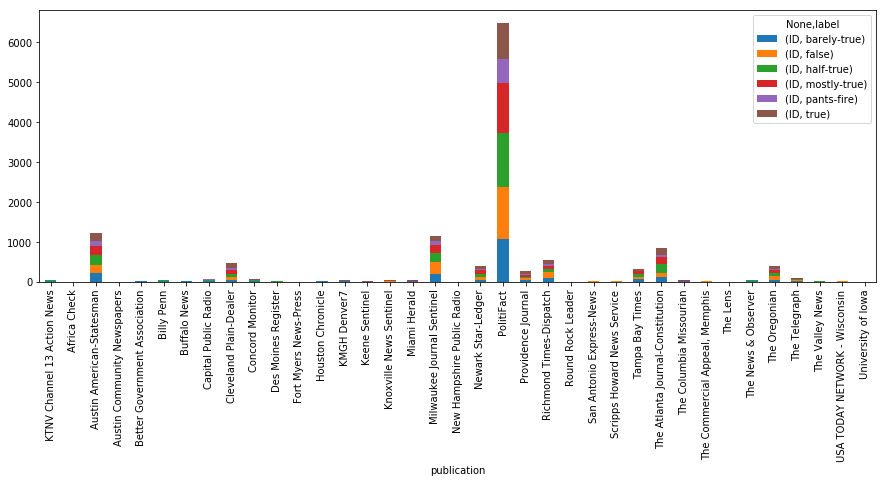

In [153]:
breakdown = by_label(publ_label, 'publication')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

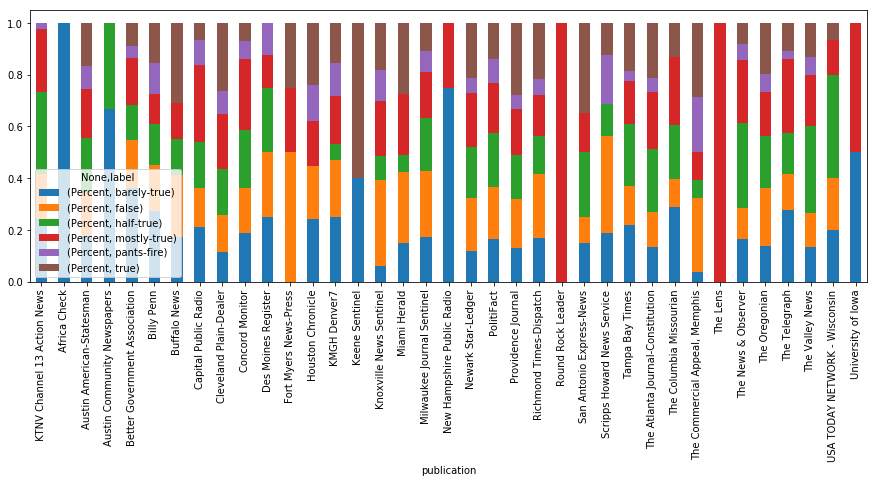

In [154]:
bd_norm = normalize(breakdown, 'publication')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

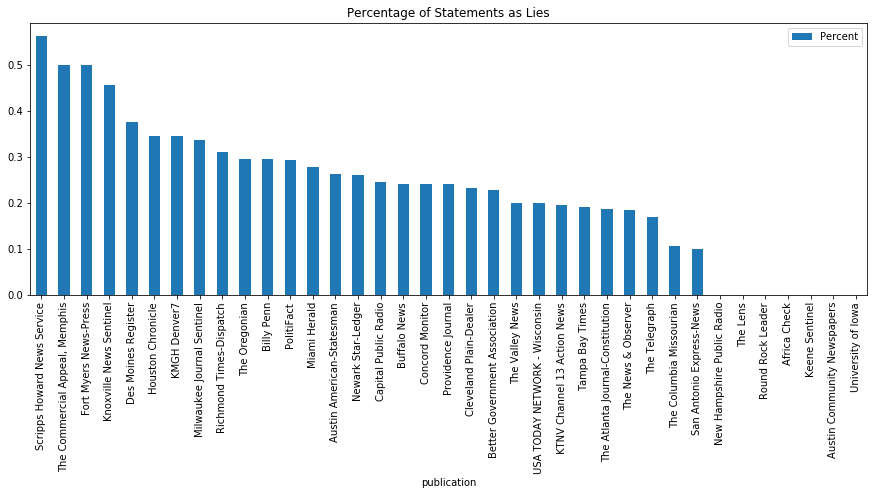

In [155]:
tf_breakdown = transform_tf(publ_label, 'publication')
bd_norm = normalize_tf(tf_breakdown, 'publication')
plot_truthfulness(bd_norm, 'publication')

# Fake news detector from headlines

Most of the time we have to deal with a great amount of news that try to be "catchy" from their title or headline but they eventually reveal themselves as false or barely reliable. We want to train a model in order to detect fake news from the headlines.

## Data loading and preparation

In [160]:
# Loading data from politifact
train_hd = pol_train_set[["id", "ruling_headline"]]
test_hd = pol_test_set[["id", "ruling_headline"]]
valid_hd = pol_valid_set[["id", "ruling_headline"]]

In [162]:
# Merging with the liar dataset and taking labels

df_raw["id_clean"] = df_raw.ID.str[:-5]
df_raw.id_clean = pd.to_numeric(df_raw.id_clean)

test_data["id_clean"] = test_data.ID.str[:-5]
test_data.id_clean = pd.to_numeric(test_data.id_clean)

valid_data["id_clean"] = valid_data.ID.str[:-5]
valid_data.id_clean = pd.to_numeric(valid_data.id_clean)

train_hd = train_hd.merge(df_raw, left_on="id", right_on="id_clean")[["ruling_headline", "label"]]
test_hd = test_hd.merge(test_data, left_on="id", right_on="id_clean")[["ruling_headline", "label"]]
valid_hd = valid_hd.merge(valid_data, left_on="id", right_on="id_clean")[["ruling_headline", "label"]]

## Data exploration

In [82]:
# Dimension of the data

# Train
print("Train data dimension:", train_hd.shape[0])

# Test
print("Test data dimension:", test_hd.shape[0])

# Validation
print("Validation data dimension:", valid_hd.shape[0])

Train data dimension: 10220
Test data dimension: 1237
Validation data dimension: 1255


In [83]:
# Mean of the number of words per headline

# Train
num_words = train_hd.ruling_headline.str.split().str.len()
print("Train set, average ruling_headline length in words:", np.mean(num_words))

# Test
num_words = test_hd.ruling_headline.str.split().str.len()
print("Test set, average ruling_headline length in words:", np.mean(num_words))

# Validation
num_words = valid_hd.ruling_headline.str.split().str.len()
print("Validation set, average ruling_headline length in words:", np.mean(num_words))

Train set, average ruling_headline length in words: 7.658023483365949
Test set, average ruling_headline length in words: 5.129345189975748
Validation set, average ruling_headline length in words: 5.260557768924302


In [84]:
# Median of the number of words per headline

# Train
num_words = train_hd.ruling_headline.str.split().str.len()
print("Train set, median value of the ruling_headline length in words:", np.median(num_words))

# Test
num_words = test_hd.ruling_headline.str.split().str.len()
print("Test set, median value of the ruling_headline length in words:", np.median(num_words))

# Validation
num_words = valid_hd.ruling_headline.str.split().str.len()
print("Validation set, median value of the ruling_headline length in words:", np.median(num_words))

Train set, median value of the ruling_headline length in words: 8.0
Test set, median value of the ruling_headline length in words: 5.0
Validation set, median value of the ruling_headline length in words: 5.0


In [85]:
def plot_length_statement_distr(data):
    # Plot the distribution of the length of the tweets

    lengths = data.apply(lambda x: len(x.split()))
    plt.hist(lengths, log=True)
    plt.xlabel('Length of statement')
    plt.ylabel('Number of statements')
    plt.show()

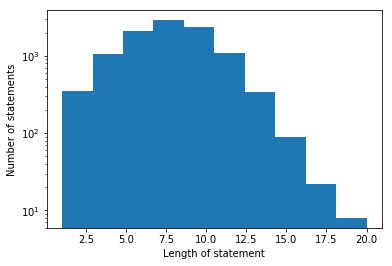

In [86]:
plot_length_statement_distr(train_hd.ruling_headline)

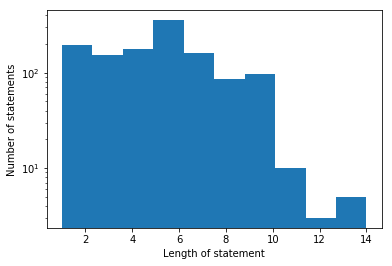

In [87]:
plot_length_statement_distr(test_hd.ruling_headline)

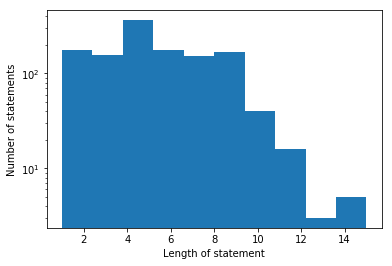

In [88]:
plot_length_statement_distr(valid_hd.ruling_headline)

In [89]:
def plot_label_distribution(data):
    return sn.countplot(x='label', data=data, palette='hls')

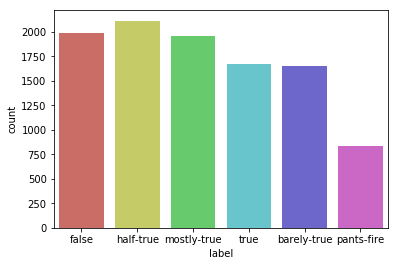

In [90]:
plot_label_distribution(train_hd)

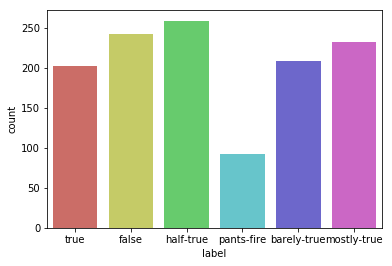

In [91]:
plot_label_distribution(test_hd)

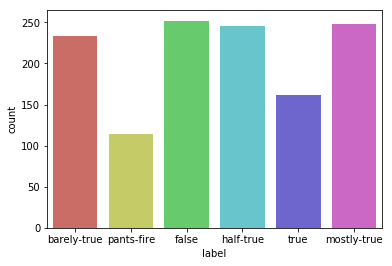

In [92]:
plot_label_distribution(valid_hd)

In [93]:
def plot_freq_word(data):

    all_words = []
    for t in data.values:
        for w in t.split():
            if len(w) > 3:
                all_words.append(w)

    all_words_df = pd.Series(all_words)
    words_count = pd.DataFrame(all_words_df.groupby(all_words_df.values).count().sort_values(ascending=False)).reset_index()
    words_count.columns = ["word", "count"]
    words_count.head(20).plot.bar(x="word", y="count")

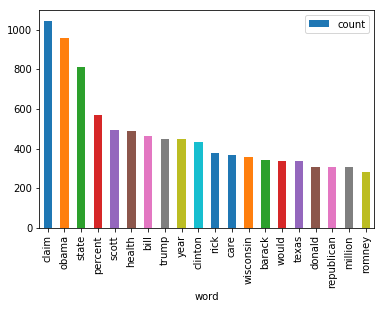

In [94]:
plot_freq_word(train_hd.ruling_headline)

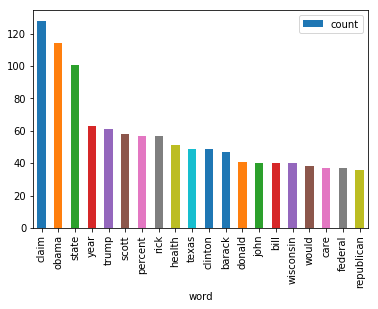

In [95]:
plot_freq_word(test_hd.ruling_headline)

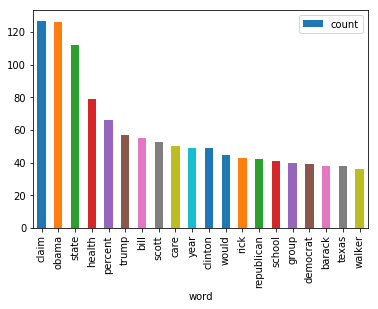

In [96]:
plot_freq_word(valid_hd.ruling_headline)

## Data preprocessing

In [141]:
# Let's clean the data

def clean_data(hd_df, feat):

    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing tags
    hd_df[feat] = hd_df[feat].str.replace('<.*?>','')

    # Removing possible mentions or urls (don't know if it's necessary but might be) 
    hd_df[feat] = hd_df[feat].str.replace('@\w+','')
    hd_df[feat] = hd_df[feat].str.replace('http.?://[^\s]+[\s]?','')

    # Removing punctuation and symbols
    hd_df[feat] = hd_df[feat].str.replace('[^\w\s]', '')
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x for x in x.split() if x not in string.punctuation))

    # Removing non alphabetical character
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

    # Removing characters non longer than 1
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))

    # Removing stopwords
    sw = stopwords.words('english')
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

    # Removing digits
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))

    # Removing words that appear less than 5
    word_freq = pd.Series(' '.join(hd_df[feat]).split()).value_counts()
    less_freq = word_freq[word_freq < 5]
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

    # Removing multiple spaces
    hd_df[feat] = hd_df[feat].apply(lambda x: x.strip())
    hd_df[feat] = hd_df[feat].str.replace(' +',' ')

    # Lemmatization (better than stemmatization imho)
    hd_df[feat] = hd_df[feat].apply(lambda x: " ".join([Word(w).lemmatize() for w in x.split()]))

    # Removing blank lines
    hd_df.drop(hd_df[hd_df[feat] == ""].index, inplace=True)
    
    # Removing possible duplicates
    hd_df[feat].drop_duplicates(inplace=True)

    return hd_df

In [31]:
clean_train_df = clean_data(train_hd, "ruling_headline")
clean_test_df = clean_data(test_hd, "ruling_headline")
clean_valid_df = clean_data(valid_hd, "ruling_headline")

## NLTK Naive Bayes

In [34]:
# Converting dataframes to list of tuples
labeled_list_tr = [tuple(x) for x in train_hd.values]
labeled_list_te = [tuple(x) for x in test_hd.values]
labeled_list_va = [tuple(x) for x in valid_hd.values]

import random
random.shuffle(labeled_list_tr)
random.shuffle(labeled_list_te)
random.shuffle(labeled_list_va)

In [35]:
all_words = set(word.lower() for passage in labeled_list_tr for word in word_tokenize(passage[0]))
train_set = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in labeled_list_tr]
classifier = NaiveBayesClassifier.train(train_set)

In [36]:
all_words_te = set(word.lower() for passage in labeled_list_te for word in word_tokenize(passage[0]))
test_set = [({word: (word in word_tokenize(x[0])) for word in all_words_te}, x[1]) for x in labeled_list_te]

In [37]:
print(classify.accuracy(classifier, test_set))

0.25060630557801133


## TextBlob Naive Bayes

In [233]:
from textblob.classifiers import NaiveBayesClassifier

tb_classifier = NaiveBayesClassifier(labeled_list_tr)

In [234]:
tb_classifier.accuracy(labeled_list_te)

0.2456556082148499

## Sklearn classifiers

In [97]:
CLEAN_TRAIN = DATA_FOLDER + "train_clean.txt"
CLEAN_TEST = DATA_FOLDER + "test_clean.txt"
CLEAN_VALID = DATA_FOLDER + "valid_clean.txt"

In [256]:
train_hd.ruling_headline.to_csv(CLEAN_TRAIN, header=False, index=False, sep=" ")
subprocess.call(["sed -i 's/\"//g' " + CLEAN_TRAIN], shell=True)

test_hd.ruling_headline.to_csv(CLEAN_TEST, header=False, index=False, sep=" ")
subprocess.call(["sed -i 's/\"//g' " + CLEAN_TEST], shell=True)

valid_hd.ruling_headline.to_csv(CLEAN_VALID, header=False, index=False, sep=" ")
subprocess.call(["sed -i 's/\"//g' " + CLEAN_VALID], shell=True)

0

In [244]:
train_data_clean = pd.read_csv(CLEAN_TRAIN, header=None, delimiter="\n", names=["headline"])
test_data_clean = pd.read_csv(CLEAN_TEST, header=None, delimiter="\n", names=["headline"])
valid_data_clean = pd.read_csv(CLEAN_VALID, header=None, delimiter="\n", names=["headline"])

In [107]:
# Building features from text
import pickle

def getFeatures(fileName):
    # Loading embeddings created before
    embeddings = np.load("data/embeddings.npy")
    feat_repr = []
    with open('data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
        with open(fileName) as file:
            for line in file:
                tokens = [vocab.get(t, -1) for t in line.strip().split()]
                tokens = [t for t in tokens if t >= 0]
                embed_sum = np.zeros(embeddings.shape[1])
                for t in tokens:
                    embed_sum = np.sum([embed_sum, embeddings[t]], axis=0)
                feat_repr.append(embed_sum/len(tokens))
    return feat_repr

In [108]:
train_feat = getFeatures(CLEAN_TRAIN)
test_feat = getFeatures(CLEAN_TEST)
valid_feat = getFeatures(CLEAN_VALID)

In [114]:
# Splitting data and get labels
from sklearn.utils import shuffle

train_clean = np.array(train_feat)
test_clean = np.array(test_feat)
valid_clean = np.array(valid_feat)

train_labels = train_hd.label.values
test_labels = test_hd.label.values
valid_labels = valid_hd.label.values

train_data, train_labels = shuffle(train_clean, train_labels)
test_data, test_labels = shuffle(test_clean, test_labels)
valid_data, valid_labels = shuffle(valid_clean, valid_labels)

## Random forest

In [115]:
rforest = RandomForestClassifier()

rforest.fit(train_data, train_labels)

y_pred = rforest.predict(test_data)

/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [116]:
# Accuracy
accuracy_score(test_labels, y_pred)

0.1883589329021827

## Naive Bayes

In [119]:
from sklearn.naive_bayes import *

bayes = GaussianNB()

bayes.fit(train_data, train_labels)

y_pred = bayes.predict(test_data)

In [120]:
# Accuracy
accuracy_score(test_labels, y_pred)

0.20776071139854488

## Logistic regression

In [121]:
logistic = LogisticRegression()

logistic.fit(train_data, train_labels)

y_pred = logistic.predict(test_data)

/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [123]:
# Accuracy
accuracy_score(test_labels, y_pred)

0.21503637833468067

## Support vector machine

In [129]:
from sklearn import *

# Training with Linear SVM
svm_class = svm.LinearSVC()

svm_class.fit(train_data, train_labels)

y_pred = svm_class.predict(test_data)

In [130]:
# Accuracy
accuracy_score(test_labels, y_pred)

0.21099434114793855

# Lies detector from statements

The idea is to replicate the result obtained by the paper of reference and see if we can detect lies from the statements given.

## Data loading and preparation

In [137]:
def load_data(path):
    columns = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
    data = pd.read_table(path, header=None)
    data.columns = columns
    return data

train_data = load_data(TRAIN_PATH)
test_data = load_data(TEST_PATH)
valid_data = load_data(VALID_PATH)

train_data = train_data[["label", "statement"]]
test_data = test_data[["label", "statement"]]
valid_data = valid_data[["label", "statement"]]

## Data exploration

In [39]:
# Dimension of the data

# Train
print("Train data dimension:", train_data.shape[0])

# Test
print("Test data dimension:", test_data.shape[0])

# Validation
print("Validation data dimension:", valid_data.shape[0])

Train data dimension: 10240
Test data dimension: 1267
Validation data dimension: 1284


In [40]:
# Mean of the number of words per statement

# Train
num_words = train_data.statement.str.split().str.len()
print("Train set, average statement length in words:", np.mean(num_words))

# Test
num_words = test_data.statement.str.split().str.len()
print("Test set, average statement length in words:", np.mean(num_words))

# Validation
num_words = valid_data.statement.str.split().str.len()
print("Validation set, average statement length in words:", np.mean(num_words))

Train set, average statement length in words: 18.01005859375
Test set, average statement length in words: 18.40410418310971
Validation set, average statement length in words: 17.925233644859812


In [41]:
# Median of the number of words per statement

# Train
num_words = train_data.statement.str.split().str.len()
print("Train set, median value of the statement length in words:", np.median(num_words))

# Test
num_words = test_data.statement.str.split().str.len()
print("Test set, median value of the statement length in words:", np.median(num_words))

# Validation
num_words = valid_data.statement.str.split().str.len()
print("Validation set, median value of the statement length in words:", np.median(num_words))

Train set, median value of the statement length in words: 17.0
Test set, median value of the statement length in words: 16.0
Validation set, median value of the statement length in words: 17.0


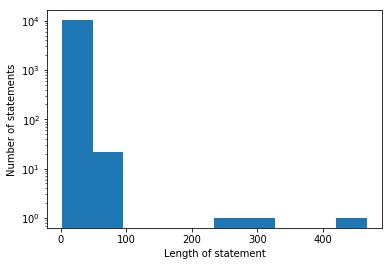

In [49]:
plot_length_statement_distr(train_data.statement)

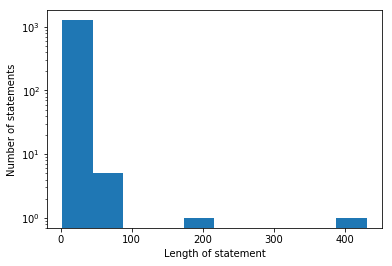

In [50]:
plot_length_statement_distr(test_data.statement)

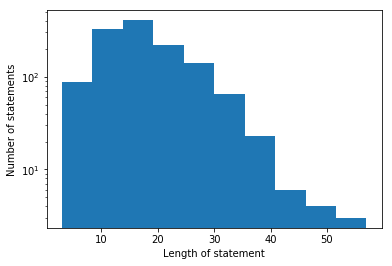

In [51]:
plot_length_statement_distr(valid_data.statement)

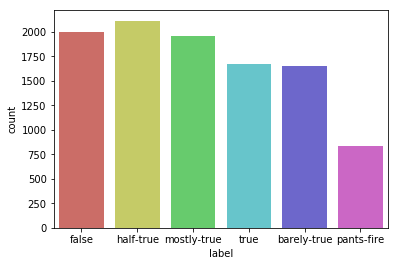

In [53]:
plot_label_distribution(train_data)

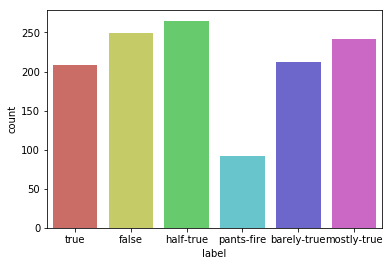

In [54]:
plot_label_distribution(test_data)

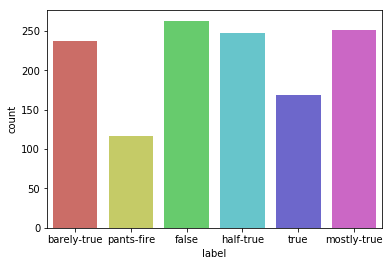

In [55]:
plot_label_distribution(valid_data)

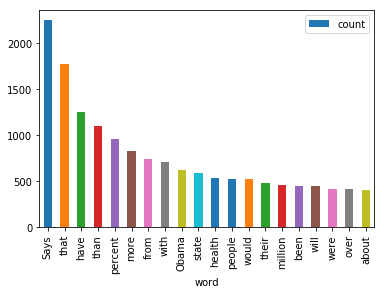

In [61]:
plot_freq_word(train_data.statement)

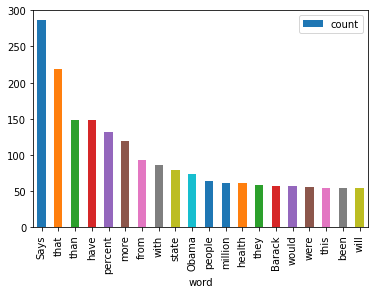

In [62]:
plot_freq_word(test_data.statement)

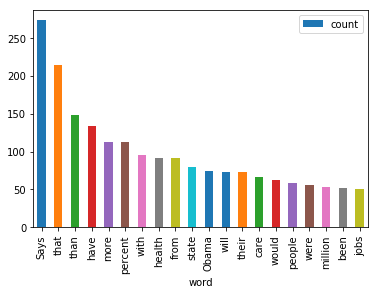

In [63]:
plot_freq_word(valid_data.statement)

## Data preprocessing

In [142]:
clean_train_df = clean_data(train_data, "statement")
clean_test_df = clean_data(test_data, "statement")
clean_valid_df = clean_data(valid_data, "statement")

## NLTK Naive Bayes

## Text Blob Naive Bayes